In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import heapq
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
df=pd.read_csv('mutagenicity_kNN.csv')
df.head()

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897
4,4,5,100-12-9,O=[N+]([O-])c1ccc(cc1)CC,Training,0,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.1572


Checking for missing values

In [7]:
print(df.isnull().values)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Checking correlation values to determine which descriptor best predicts mutagenicity

In [8]:
numeric_df=df.select_dtypes(include=np.number)
numeric_df.head()

,Unnamed: 0,Id,Experimental value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,0,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,1,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897
4,4,5,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.1572


In [9]:
correlation=numeric_df.corr()['Experimental value']
correlation

,Experimental value
Unnamed: 0,0.032185
Id,0.032159
Experimental value,1.000000
NumValenceElectrons,-0.010744
qed,-0.143388
TPSA,0.065954
MolMR,0.028477
BalabanJ,-0.064472
BertzCT,0.171867
MolWt,-0.001153


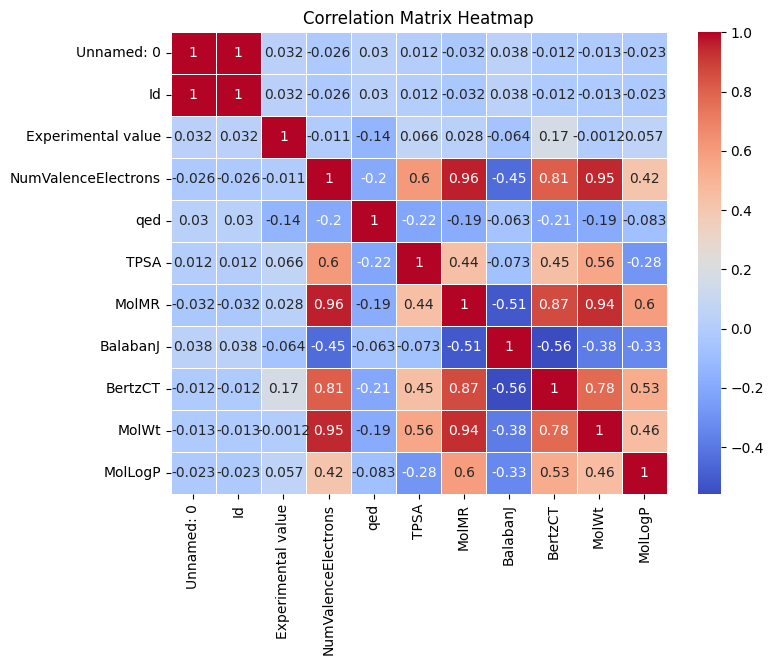

In [26]:
corr=numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
x=numeric_df.drop(['Experimental value','Id','Unnamed: 0','MolWt'],axis=1) #removing unnecessary features
y=df['Predicted value']

In [12]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

In [13]:
def evaluate(y_test,y_pred):
    accuracy= accuracy_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    print("Precision:",precision_score(y_test, y_pred, average='weighted'))
    print("Recall:",recall_score(y_test, y_pred, average='weighted'))

In [14]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [15]:
y_pred= knn.predict(x_test)
evaluate(y_test,y_pred)

F1 Score: 0.7514402485997713
Accuracy: 0.753686036426713
Precision: 0.7510394509893944
Recall: 0.753686036426713


In [16]:
param_grid_knn = {'n_neighbors': np.arange(5,51), 'weights': ['distance','uniform'],
                  'metric': [ 'minkowski','euclidean','manhattan']}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=4, scoring='f1')
grid_search_knn.fit(x_train, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)

Best Parameters for KNN: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}


In [17]:
y_pred= grid_search_knn.best_estimator_.predict(x_test)
evaluate(y_test,y_pred)

F1 Score: 0.7755053812341784
Accuracy: 0.777103209019948
Precision: 0.7748354269166289
Recall: 0.777103209019948


In [18]:
strat_kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(grid_search_knn.best_estimator_, x_scaled, y,
                            cv=strat_kfold, scoring='f1_weighted')                                #The f1 metric requires both classes (0 and 1) to be present in each fold. If a fold only contains one class, you'll get a NaN score. To handle this, switch to f1_weighted, which accounts for class imbalance by weighting the F1-score based on the class distribution.
print("Cross-validated F1-Score:", np.mean(cv_scores))

Cross-validated F1-Score: 0.7173422833766908


Cosine similarity model

In [19]:
def cos_knn(k, x_test, y_test, x_train, y_train):
    cosine_similarity_matrix = cosine_similarity(x_test, x_train)
    knn_=KNeighborsClassifier(n_neighbors=k, metric='cosine',weights='distance')
    knn_.fit(x_train, y_train)
    y_pred = knn_.predict(x_test)
    evaluate(y_test, y_pred)
    strat_kfold = StratifiedKFold(n_splits=10)
    cv_scores = cross_val_score(knn, x_scaled, y, cv=strat_kfold, scoring='accuracy')
    print("Cross-validated F1-Score using Cosine Similarity:", np.mean(cv_scores))


In [20]:
cos_knn(9,x_test,y_test,x_train,y_train)

F1 Score: 0.7403828171521133
Accuracy: 0.7406764960971379
Precision: 0.7402276049487317
Recall: 0.7406764960971379
Cross-validated F1-Score using Cosine Similarity: 0.7099241165992682


Trying out other algorithms like ball tree and auto

In [21]:
knn_ball=KNeighborsClassifier(n_neighbors=3, metric='manhattan'
                              ,weights='uniform', algorithm='ball_tree')
knn_ball.fit(x_train, y_train)
y_pred = knn_ball.predict(x_test)
evaluate(y_test, y_pred)

F1 Score: 0.7503216513374745
Accuracy: 0.7528187337380746
Precision: 0.7501635972926147
Recall: 0.7528187337380746


In [22]:
param_grid_knn_ball = {'n_neighbors': np.arange(5,51),
                       'weights': ['distance','uniform'],
                       'metric': [ 'minkowski','euclidean','manhattan','l1','l2']}
grid_search_knn_ball = GridSearchCV(knn_ball, param_grid_knn_ball, cv=5, scoring='f1')
grid_search_knn_ball.fit(x_train, y_train)
print("Best Parameters for KNN:", grid_search_knn_ball.best_params_)

Best Parameters for KNN: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}


In [23]:
y_pred= grid_search_knn.best_estimator_.predict(x_test)
evaluate(y_test,y_pred)

F1 Score: 0.7755053812341784
Accuracy: 0.777103209019948
Precision: 0.7748354269166289
Recall: 0.777103209019948


In [24]:
knn_auto=KNeighborsClassifier(n_neighbors=5, metric='l2'
                              ,weights='distance', algorithm='kd_tree')
knn_auto.fit(x_train, y_train)


KNeighborsClassifier(algorithm='kd_tree', metric='l2', weights='distance')

In [25]:
y_pred = knn_auto.predict(x_test)
evaluate(y_test, y_pred)

F1 Score: 0.7755053812341784
Accuracy: 0.777103209019948
Precision: 0.7748354269166289
Recall: 0.777103209019948
